# Epigenome-Wide Association Study (EWAS) to Train an SVM Classifier

Does transient exposure to nuclear reprogramming facctors cause patterns in DNA methylation predictive of rejuvenated gene expression?
To address this question, train an SVM classifier to predict "aged" or "rejuvenated" status using top 500 CpG's affected by treatment and identified by EWAS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm

## Identify ($n = 500$) most significant CpGs determined by EWAS

In [2]:
n = 500
CpGs = pd.read_csv("glint_ewas_results_top10k.txt", usecols=[0])
top_CpGs = CpGs.iloc[0:n,].values.flatten()

## Load DNA methylation data from GEO GSE142439

In [3]:
data_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/GSE142439/matrix//GSE142439_series_matrix.txt.gz'
methyl = pd.read_csv(data_url, sep='\t', skiprows=71, index_col=0)
meta_data_backup = pd.read_csv(data_url, sep='\t', skiprows=40, index_col=0, nrows=3)


In [4]:
meta_data = meta_data_backup.copy()
meta_data.columns = methyl.columns
meta_data.index = ['age', 'cell', 'treatment']
meta_data = meta_data.T
meta_data['age'] = meta_data['age'].str.replace('age: ','')
meta_data['cell'] = meta_data['cell'].str.replace('cell type: ','')
meta_data['treatment'] = meta_data['treatment'].str.replace('treatmentstatus: ','')

## Isolate DNA methylation data from top 500 CpGs

In [5]:
meta_fibroblast = meta_data[meta_data["cell"] == "skin fibroblasts"]
all_IDs = meta_fibroblast["treatment"].index.tolist()
norm_IDs = meta_fibroblast[meta_fibroblast["treatment"] == "Normal"].index.tolist()
treat_IDs = meta_fibroblast[meta_fibroblast["treatment"] == "Treated"].index.tolist()
methyl_500 = methyl.loc[top_CpGs,all_IDs]

In [6]:
norm_500 = methyl_500.loc[:, norm_IDs]
treat_500 = methyl_500.loc[:, treat_IDs]

print("Pre-treatment DNA methylation of most significant CpGs: ")
print(norm_500)
print()
print("Post-treatment DNA methylation of most significant CpGs: ")
print(treat_500)

Pre-treatment DNA methylation of most significant CpGs: 
            GSM4227385  GSM4227387  GSM4227389  GSM4227391
ID_REF                                                    
cg13502023    0.781714    0.781551    0.486792    0.660471
cg23384863    0.784160    0.706414    0.889465    0.733214
cg00320765    0.841218    0.692161    0.732697    0.504735
cg24259463    0.774138    0.697678    0.818152    0.696732
cg04223956    0.926845    0.900712    0.883346    0.921207
cg03407966    0.882892    0.856324    0.829445    0.768740
cg07403374    0.836165    0.811618    0.821408    0.805868
cg10122230    0.883074    0.865229    0.788898    0.876663
cg24603972    0.514783    0.592634    0.368652    0.315901
cg17526578    0.839289    0.874850    0.877459    0.770436
cg05619202    0.580318    0.623646    0.588919    0.537697
cg04105597    0.854069    0.887415    0.947217    0.832625
cg22278294    0.897781    0.897500    0.868279    0.765554
cg12613081    0.642116    0.587978    0.786858    0.682795

## Visualization

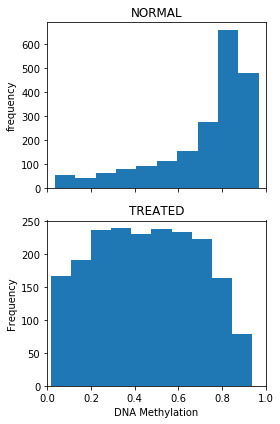

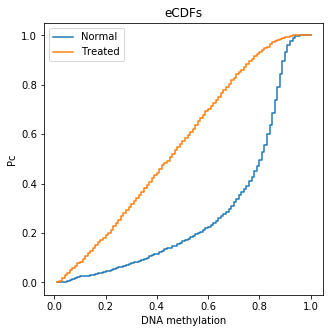

In [7]:
dx = 0.01
x = np.arange(0, 1+dx, dx)

# Histograms
fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 6))
ax1.hist(norm_500.values.flatten())
ax1.set_title("NORMAL")
ax1.set_ylabel("frequency")
ax1.set_xlim((0, 1))
ax1.get_xaxis().set_ticklabels([])
ax2.hist(treat_500.values.flatten())
ax2.set_title("TREATED")
ax2.set_ylabel("Frequency")
ax2.set_xlim((0, 1))
ax2.set_xlabel("DNA Methylation")
fig.tight_layout()
fig.show()

# eCDFs
norm = np.histogram(norm_500.values.flatten(), bins=x, density=True)[0]
c_norm = np.cumsum(norm * dx)
treat = np.histogram(treat_500.values.flatten(), bins=x, density=True)[0]
c_treat = np.cumsum(treat * dx)

fig = plt.figure(figsize=(5, 5))
plt.step(x[1:], c_norm, label = "Normal")
plt.step(x[1:], c_treat, label = "Treated")
plt.xlabel("DNA methylation")
plt.ylabel("Pc")
plt.title("eCDFs")
plt.legend(loc="best")
fig.show()


## Train an SVM classifier

In [8]:
X = methyl_500.values.T
y = [int(ID in treat_IDs) for ID in all_IDs]    # Encode "Normal" = 0; "Treated" = 1
clf = svm.SVC()
clf.fit(X, y)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## Evaluate Performace